In [278]:
import numpy as np
import pandas as pd

In [279]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [280]:
import itertools
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

In [281]:
def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  # df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [282]:
X, y, class_names, _ = load_pose_landmarks('data_set.csv')
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_train = X.copy()
y_train = y.copy()

X_val = X.copy()
y_val = y.copy()

In [253]:
y_train

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [283]:
X_test, y_test, _, df_test = load_pose_landmarks('data_set.csv')

In [284]:
inputs = tf.keras.Input(shape=(132))

layer = keras.layers.Dense(512, activation=tf.nn.sigmoid)(inputs)
layer = keras.layers.Dense(512, activation=tf.nn.sigmoid)(layer)
layer = keras.layers.Dense(256, activation=tf.nn.sigmoid)(layer)
layer = keras.layers.Dense(256, activation=tf.nn.sigmoid)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 132)]             0         
                                                                 
 dense_25 (Dense)            (None, 512)               68096     
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 3)                 771       
                                                                 
Total params: 528,643
Trainable params: 528,643
Non-trainab

In [287]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [288]:
# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=100)

In [289]:
# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
 91/104 [=========================>....] - ETA: 0s - loss: 1.0740 - accuracy: 0.4622
Epoch 1: val_accuracy improved from -inf to 0.73640, saving model to weights.best.hdf5
104/104 [==============================] - 1s 7ms/step - loss: 1.0304 - accuracy: 0.4891 - val_loss: 0.5327 - val_accuracy: 0.7364
Epoch 2/200
 92/104 [=========================>....] - ETA: 0s - loss: 0.3218 - accuracy: 0.8696
Epoch 2: val_accuracy improved from 0.73640 to 1.00000, saving model to weights.best.hdf5
104/104 [==============================] - 1s 5ms/step - loss: 0.2964 - accuracy: 0.8827 - val_loss: 0.0528 - val_accuracy: 1.0000
Epoch 3/200
 89/104 [========================>.....] - ETA: 0s - loss: 0.0357 - accuracy: 0.9986
Epoch 3: val_accuracy did not improve from 1.00000
104/104 [==============================] - 1s 6ms/step - loss: 0.0367 - accuracy: 0.9970 - val_loss: 0.0434 - val_accuracy: 0.9746
Epoch 4/200
 96/104 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy

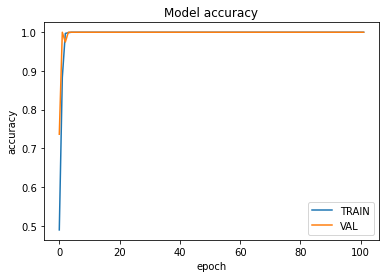

In [290]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [291]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

52/52 [==============================] - 0s 3ms/step - loss: 1.4826e-06 - accuracy: 1.0000


In [292]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

    standing       1.00      1.00      1.00       723
      t-pose       1.00      1.00      1.00       500
      x-pose       1.00      1.00      1.00       431

    accuracy                           1.00      1654
   macro avg       1.00      1.00      1.00      1654
weighted avg       1.00      1.00      1.00      1654



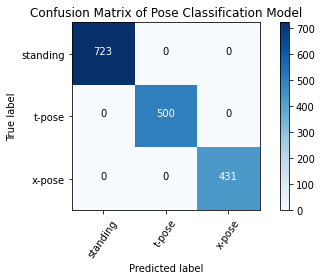

In [293]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [294]:
print(class_names[np.argmax(model.predict(X_test.iloc[:1, :]), axis=1)][0])

standing


In [295]:
def predictFromLandMark(landmarkList):
    temp = np.zeros(132)
    for i in range(len(landmarkList)):
        # df[str(4*i)] = [landmarkList[i].x]
        # df[str(4*i + 1)] = [landmarkList[i].y]
        # df[str(4*i + 2)] = [landmarkList[i].z]
        # df[str(4*i + 3)] = [landmarkList[i].visibility]
        temp[4*i] = landmarkList[i].x
        temp[4*i + 1] = landmarkList[i].x
        temp[4*i + 2] = landmarkList[i].y
        temp[4*i + 3] = landmarkList[i].visibility
    df = pd.DataFrame([temp], columns=np.arange(132))
    return class_names[np.argmax(model.predict(df.iloc[:1, :]), axis=1)][0]

In [296]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

t-pose


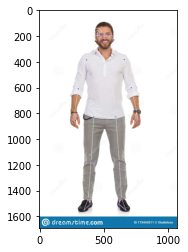

In [297]:
test_img = cv2.cvtColor(cv2.imread('test2.jpg'),cv2.COLOR_BGR2RGB)
results = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5).process(test_img)
print(predictFromLandMark(results.pose_landmarks.landmark))
mp_drawing.draw_landmarks(test_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
plt.imshow(test_img)
plt.show()


# [results.pose_landmarks.landmark]

In [306]:
def predictFromVideo(video_name, isWebCam=False):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,50)
    fontScale              = 0.5
    fontColor              = (255,0,0)
    thickness              = 1
    lineType               = 2

    if (isWebCam):
        cap = cv2.VideoCapture(0)
    else:
        cap = cv2.VideoCapture(video_name)
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # image.flags.writeable = False

            results = pose.process(image)

            # image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            resized_img = cv2.resize(image, (394, 700))
            
            if results.pose_landmarks is None:
                classified_pose_name = "Calculating!!"
            else:
                classified_pose_name = predictFromLandMark(results.pose_landmarks.landmark)
            # display(resized_img)
            cv2.putText(resized_img, "Predict result: " + classified_pose_name, 
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                thickness,
                lineType)
            cv2.imshow("show pose predict",resized_img)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            
    cap.release()
    # out.release()
    cv2.destroyAllWindows()

In [220]:
predictFromVideo('heart-pose-sample.mp4')

In [299]:
predictFromVideo('sample/standing-sample.mp4')

In [300]:
predictFromVideo('sample/standing-sample-2.mp4')

In [301]:
predictFromVideo('sample/t-pose-sample.mp4')

In [302]:
predictFromVideo('sample/x-pose-sample.mp4')

In [307]:
predictFromVideo('test/test-video-1.mp4')